<a href="https://colab.research.google.com/github/Perniciosius/Pan-Tompkins-Algorithm/blob/master/PanTompkins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pan–Tompkins algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [ ]:
from scipy.signal import butter, lfilter
from scipy import io

In [ ]:
# Function to find peaks
def findpeaks(data, spacing=1, limit=None):
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peakCandidate = np.zeros(len)
        peakCandidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]
            start = spacing
            h_c = x[start: start + len]
            start = spacing + s + 1
            h_a = x[start: start + len]
            peakCandidate = np.logical_and(peakCandidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peakCandidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind


In [ ]:
# Function to find QRS from peaks
def filterQRS(signalPeaksIndices, signalPeakValues):
  refractoryPeriod = 120
  thresholdValue = 0.0
  qrsPeakIndices = np.array([], int)
  qrsPeakValue = 0.0
  noisePeakIndices = np.array([], int)
  noisePeakValue = 0.0
  qrsPeakFilteringFactor = 0.125
  noisePeakFilteringFactor = 0.125
  qrsNoiseDiffWeight = 0.25
  for peakIndex, peakValue in zip(signalPeaksIndices, signalPeakValues):
    try:
      lastQrsIndex = qrsPeakIndices[-1]
    except:
      lastQrsIndex = 0
    if peakIndex - lastQrsIndex > refractoryPeriod or not qrsPeakIndices.size:
      if peakValue > thresholdValue:
        qrsPeakIndices = np.append(qrsPeakIndices, peakIndex)
        qrsPeakValue = qrsPeakFilteringFactor * peakValue + (1 - qrsPeakFilteringFactor) * qrsPeakValue
      else:
        noisePeakIndices = np.append(noisePeakIndices, peakIndex)
        noisePeakValue = noisePeakFilteringFactor * peakValue + (1 - noisePeakFilteringFactor) * noisePeakValue
    thresholdValue = noisePeakValue + qrsNoiseDiffWeight * (qrsPeakValue - noisePeakValue)
  qrsPeakIndices = qrsPeakIndices[integratedSignal[qrsPeakIndices] > thresholdValue]
  return qrsPeakIndices

In [ ]:
def PanTompkinsAlgorithm(ecgSignal):
  plt.figure(figsize = (10, 20))
  plt.tight_layout()
  plt.subplot(4, 2, 1)
  plt.plot(ecgSignal)
  plt.title('Original Signal')

  # Bandpass Filtering
  samplingFrequency = 220
  nyquistFrequency = 0.5 * samplingFrequency
  low = 5 / nyquistFrequency
  high = 15 / nyquistFrequency
  b, a = butter(1, [low, high], 'band')
  filteredSignal = lfilter(b, a, ecgSignal)
  plt.subplot(4, 2, 2)
  plt.plot(filteredSignal)
  plt.title('After bandpass filtering')

  # Differentiation
  filteredSignal[:5] = filteredSignal[5]
  differentiatedSignal = np.ediff1d(filteredSignal)
  plt.subplot(4, 2, 3)
  plt.plot(differentiatedSignal)
  plt.title('After differentiation')

  # Squaring
  squaredSignal = differentiatedSignal ** 2
  plt.subplot(4, 2, 4)
  plt.plot(squaredSignal)
  plt.title('After squaring')

  # Integration
  integratedSignal = np.convolve(squaredSignal, np.ones(15))
  plt.subplot(4, 2, 5)
  plt.plot(integratedSignal)
  plt.title('After integrating')

  # Find peaks
  signalPeaksIndices = findpeaks(integratedSignal, 50, 0.35)
  signalPeakValues = integratedSignal[signalPeaksIndices]
  plt.subplot(4, 2, 6)
  plt.plot(integratedSignal)
  plt.scatter(signalPeaksIndices, signalPeakValues, c = 'red')
  plt.title('Peaks')

  # Find QRS from peaks
  qrsPeakIndices = filterQRS(signalPeaksIndices, signalPeakValues)
  plt.subplot(4, 2, 7)
  plt.plot(integratedSignal)
  plt.title('QRS')
  plt.scatter(qrsPeakIndices, integratedSignal[qrsPeakIndices], c = 'red')

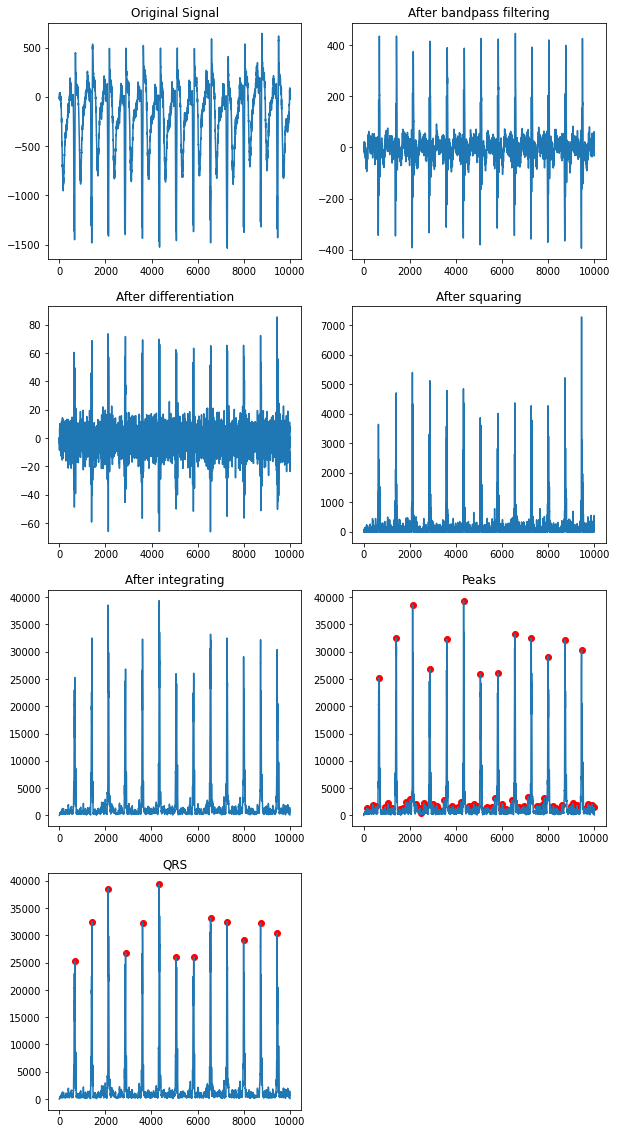

In [ ]:
# Load ecg data from dataset
ecgSignal = io.loadmat('s0010_rem.mat')['val']
# Pass ecg data to function
PanTompkinsAlgorithm(ecgSignal[2])